In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_curve,roc_auc_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

## Preprocessing Data

### Creating dummy variables

In [4]:
# Import the data
music_df = pd.read_csv('../data/music_clean.csv')

# Create music_dummies
#music_dummies = pd.get_dummies(music_df,drop_first=True)

# Print the new DataFrame's shape
#print("Shape of music_dummies: {}".format(music_dummies.shape))



     Unnamed: 0  popularity  acousticness  danceability  duration_ms  energy  \
0         36506        60.0      0.896000         0.726     214547.0  0.1770   
1         37591        63.0      0.003840         0.635     190448.0  0.9080   
2         37658        59.0      0.000075         0.352     456320.0  0.9560   
3         36060        54.0      0.945000         0.488     352280.0  0.3260   
4         35710        55.0      0.245000         0.667     273693.0  0.6470   
..          ...         ...           ...           ...          ...     ...   
995       44501        57.0      0.972000         0.193     208040.0  0.0329   
996       25114        56.0      0.005790         0.939     144453.0  0.3730   
997       46896        54.0      0.016100         0.739     238339.0  0.5390   
998       45135        62.0      0.326000         0.515     286707.0  0.5050   
999       18960        42.0      0.029500         0.291     194679.0  0.5980   

     instrumentalness  liveness  loudne

### Regression with categorical features

In [10]:
# Create kf by calling KFold(), setting the number of splits to six, shuffle to True, and setting a seed of 5
kf =KFold(n_splits=3, shuffle=True, random_state=42)

# Create X, containing all features in music_dummies, and y, consisting of the "popularity" column, respectively.
X = music_df.drop('popularity', axis=1).values
y = music_df['popularity'].values

# Instantiate a ridge regression model, setting alpha equal to 0.2
ridge = Ridge(alpha=0.2)

# Perform cross-validation on X and y using the ridge model, setting cv equal to kf, and using negative mean squared error as the scoring metric.
scores = cross_val_score(ridge, X, y, cv=kf, scoring="neg_mean_squared_error")

# Print the RMSE values by converting negative scores to positive and taking the square root
rmse = np.sqrt(-scores)
print("Average RMSE: {}".format(np.mean(rmse)))
print("Standard Deviation of the target array: {}".format(np.std(y)))

Average RMSE: 10.107171978159725
Standard Deviation of the target array: 14.02156909907019


## Handling Missing Data

### Dropping missing data

In [11]:
# Print the number of missing values for each column in the music_df dataset, sorted in ascending order.
print(music_df.isna().sum().sort_values())

# Remove values for all columns with 50 or fewer missing values.
# Remove values where less than 5% are missing
music_df = music_df.dropna(subset=["genre", "popularity", "loudness", "liveness", "tempo"])

# Convert music_df["genre"] to values of 1 if the row contains "Rock", otherwise change the value to 0.
music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

print(music_df.isna().sum().sort_values())
print("Shape of the `music_df`: {}".format(music_df.shape))

Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64


### Pipeline for song genre prediction: I

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate an imputer
imputer = SimpleImputer()

# Instantiate a KNN classifier with three neighbors.
knn = KNeighborsClassifier(n_neighbors=3)

# Create steps, a list of tuples containing the imputer variable you created, called "imputer", followed by the knn model you created, called "knn"
steps = [("imputer", imputer), 
         ("knn", knn)]

### Pipeline for song genre prediction: II

In [22]:

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training data.
pipeline.fit(X_train, y_train)

# Make predictions on the test set.
y_pred = pipeline.predict(X_test)

# Calculate and print the confusion matrix.
print(confusion_matrix(y_test,y_pred))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Cantering and Scaling

### Centering and scaling for regression

In [27]:
# Create X, containing all features in music_dummies, and y, consisting of the "popularity" column, respectively.
X = music_df.drop('loudness', axis=1).values
y = music_df['loudness'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the steps for the pipeline object, a StandardScaler object called "scaler", and a lasso model called "lasso" with alpha set to 0.5.
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=0.5))]

# Instantiate a pipeline with steps to scale and build a lasso regression model.
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Calculate the R-squared value on the test data.
print(pipeline.score(X_test, y_test))

0.7185052514704713


### Centering and scaling for classification

In [33]:
# Create X, containing all features in music_dummies, and y, consisting of the "popularity" column, respectively.
X = music_df.drop('genre', axis=1).values
y = music_df['genre'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Build the steps for the pipeline: a StandardScaler() object named "scaler", and a logistic regression model named "logreg".
steps = [("scaler", StandardScaler()),("logreg", LogisticRegression())]

pipeline = Pipeline(steps)

# Create the parameters, searching 20 equally spaced float values ranging from 0.001 to 1.0 for the logistic regression model's C hyperparameter within the pipeline.
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}

# Instantiate the grid search object.
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit the grid search object to the training data.
cv.fit(X_train,y_train)
print(cv.best_score_, "\n", cv.best_params_)

0.9275 
 {'logreg__C': np.float64(0.5267894736842105)}


## Evaluating Multiple Model

### Visualizing regression model performance

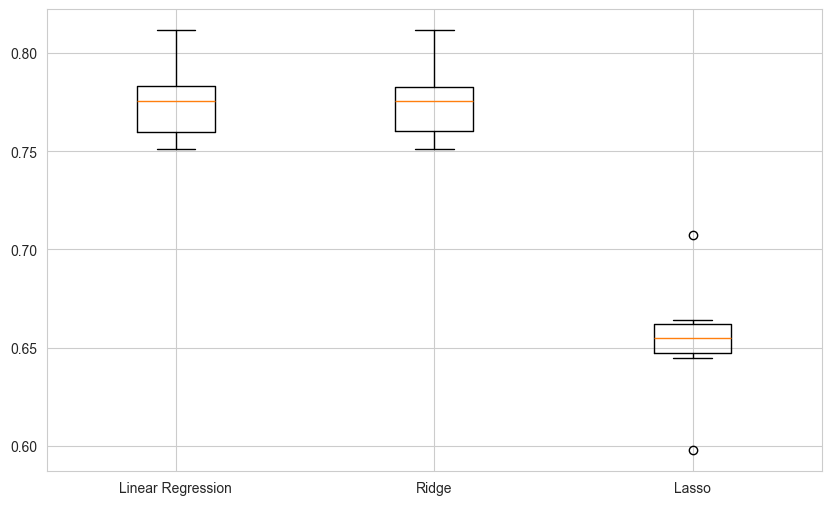

In [43]:
# Create X, containing all features in music_dummies, and y, consisting of the "energy" column, respectively.
X = music_df.drop('energy', axis=1).values
y = music_df['energy'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Write a for loop using model as the iterator, and model.values() as the iterable.
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1)}
results = []

# Loop through the models' values
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    
    # Append the results
    results.append(cv_scores)

# Create a box plot of the results
fig, ax = plt.subplots(figsize=(10, 6))
plt.boxplot(results, tick_labels=models.keys())
plt.show()
    

### Predicting on the test set

In [50]:
# Fit the model to the scaled training features and the training labels.
for name, model in models.items():
    model.fit(X_train_scaled,y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate the test_rmse
    test_rmse = mean_squared_error(y_test, y_pred)
    print("{} Test Set RMSE: {}".format(name, test_rmse))

Linear Regression Test Set RMSE: 0.012399207445322757
Ridge Test Set RMSE: 0.012399749186727411
Lasso Test Set RMSE: 0.03003163750054614


### Visualizing classification model performance

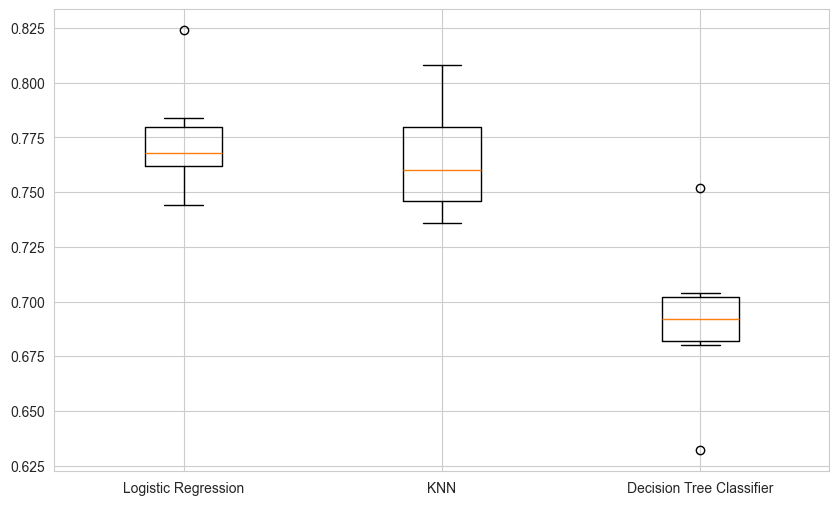

In [100]:
# Import the data
music_df = pd.read_csv('../data/music_clean.csv')

med_popular = music_df[['popularity']].median()

# Convert music_df["popularity"] to values of 1 if the value greater than it's median value else 0
music_df["popularity"] = np.where(music_df["popularity"] > med_popular.values[0],1,0)

# Create X, containing all features in music_dummies, and y, consisting of the "popularity" column, respectively.
X = music_df.drop('popularity', axis=1).values
y = music_df['popularity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a dictionary of "Logistic Regression", "KNN", and "Decision Tree Classifier", setting the dictionary's values to a call of each model
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(), "Decision Tree Classifier": DecisionTreeClassifier()}
results = []

# Loop through the values in models

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=6, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
  results.append(cv_results)

fig, ax = plt.subplots(figsize=(10, 6))
plt.boxplot(results, tick_labels=models.keys())
plt.show()

### Pipeline for predicting song popularity

In [103]:
# Create the steps for the pipeline by calling a simple imputer, a standard scaler, and a logistic regression model.
# Create steps
steps = [("imp_mean", SimpleImputer()), 
         ("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]

# Create a pipeline object, and pass the steps variable.
pipeline = Pipeline(steps)

params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 1.0, 10)}

# Instantiate a grid search object to perform cross-validation using the pipeline and the parameters.
tuning = GridSearchCV(pipeline, param_grid=params)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Print the best parameters and compute and print the test set accuracy score for the grid search object.
# Compute and print performance
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_score_, tuning.best_params_))

Tuned Logistic Regression Parameters: 0.788, Accuracy: {'logreg__C': np.float64(0.334), 'logreg__solver': 'newton-cg'}
